In [18]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [19]:
# Load datasets
customers_df = pd.read_csv("/content/drive/MyDrive/Customers.csv")
products_df = pd.read_csv("/content/drive/MyDrive/Products.csv")
transactions_df= pd.read_csv("/content/drive/MyDrive/Transactions.csv")

In [20]:
# Merge the datasets
merged_df = transactions_df.merge(customers_df, on='CustomerID', how='left')
merged_df = merged_df.merge(products_df, on='ProductID', how='left')

# Convert dates to datetime
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])

# Current date for calculating membership duration
current_date = datetime.now()

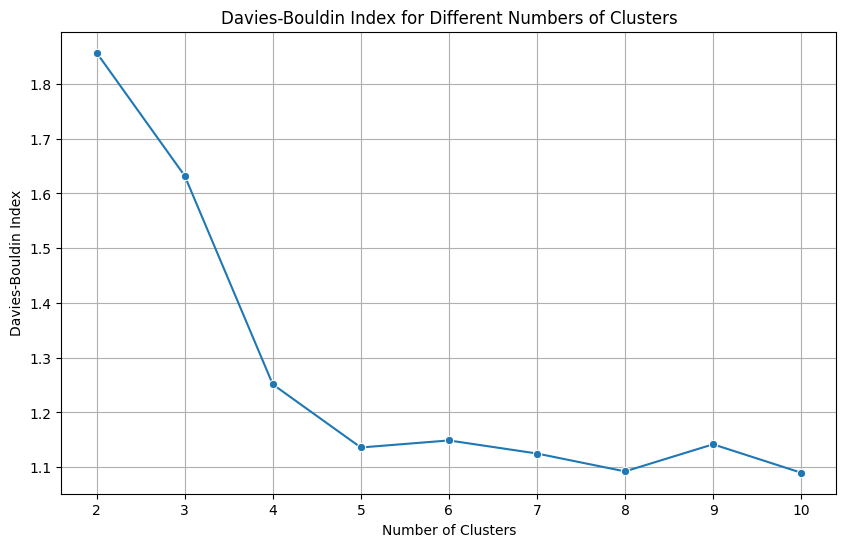

Optimal Number of Clusters: 10


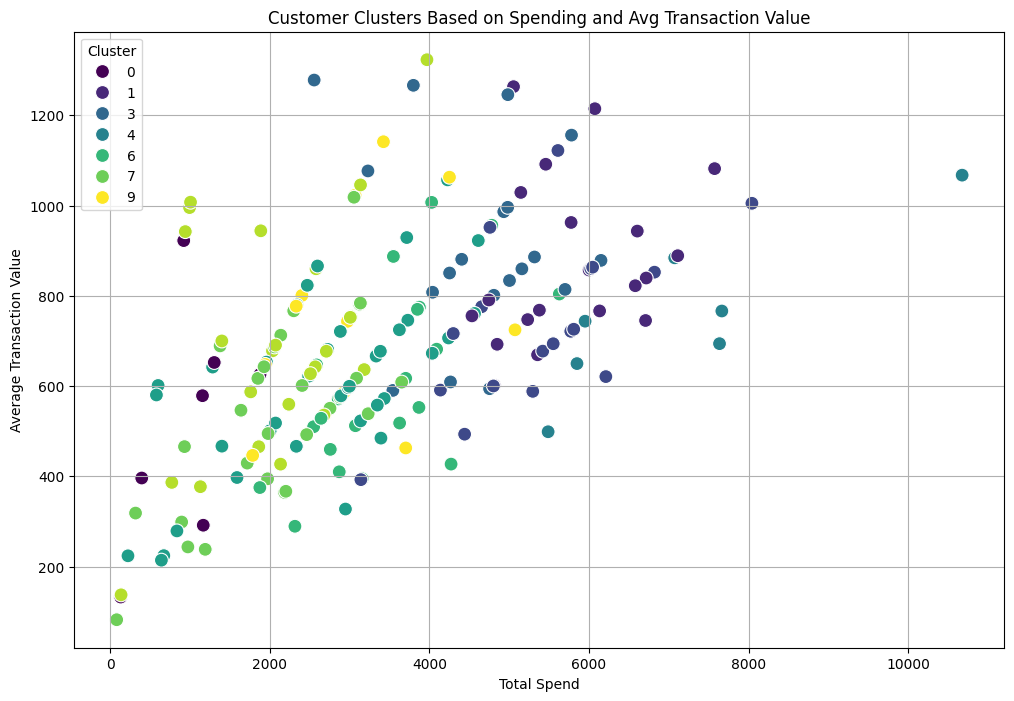

Clustering completed and results saved to 'Customer_Clusters.csv'.


In [21]:
# Feature Engineering: Customer-level metrics
customer_features = merged_df.groupby('CustomerID').agg(
    TotalSpend=('TotalValue', 'sum'),
    TransactionCount=('TransactionID', 'nunique'),
    AvgTransactionValue=('TotalValue', 'mean'),
    TotalQuantity=('Quantity', 'sum'),
    MembershipDurationDays=('SignupDate', lambda x: (current_date - x.max()).days),
    Region=('Region', 'first')
).reset_index()

# One-hot encoding for region
customer_features = pd.get_dummies(customer_features, columns=['Region'], prefix='Region')

# Normalize the numerical features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(customer_features.drop(columns=['CustomerID']))

# Optimal number of clusters range
cluster_range = range(2, 11)
db_index_scores = []

# Perform clustering and calculate DB Index for each cluster count
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(normalized_features)
    db_index = davies_bouldin_score(normalized_features, cluster_labels)
    db_index_scores.append(db_index)

# Plot DB Index for different numbers of clusters
plt.figure(figsize=(10, 6))
sns.lineplot(x=cluster_range, y=db_index_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(cluster_range)
plt.grid()
plt.show()

# Determine the best number of clusters
optimal_clusters = cluster_range[db_index_scores.index(min(db_index_scores))]
print(f"Optimal Number of Clusters: {optimal_clusters}")

# Perform clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
customer_features['Cluster'] = kmeans.fit_predict(normalized_features)

# Visualize clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=customer_features['TotalSpend'],
    y=customer_features['AvgTransactionValue'],
    hue=customer_features['Cluster'],
    palette='viridis',
    s=100
)
plt.title('Customer Clusters Based on Spending and Avg Transaction Value')
plt.xlabel('Total Spend')
plt.ylabel('Average Transaction Value')
plt.legend(title='Cluster')
plt.grid()
plt.show()

# Save clustering results
customer_features.to_csv('Customer_Clusters.csv', index=False)
print("Clustering completed and results saved to 'Customer_Clusters.csv'.")